In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import codecs
import json

from sklearn.model_selection import train_test_split
from nltk import sent_tokenize, word_tokenize

from nltk.tokenize import wordpunct_tokenize
# from nltk.tokenize import word_tokenize

from data_preparation.EMA_documents import SectionLeaflet, Leaflet

In [3]:
# load array of objects, where object - class Leaflet
with open("LeafletsDataset_section1_NER_outputs.dat", "rb") as f:
    loaded_package_leaflets = pickle.load(f)

In [4]:
len(loaded_package_leaflets)

1250

### Clean Leaflets dataset

In [5]:
loaded_package_leaflets[0].section1.section_content

'trydonis is a medicine to help breathing that contains the three active substances: beclometasone dipropionate, formoterol fumarate dihydrate and glycopyrronium. beclometasone dipropionate belongs to a group of medicines called corticosteroids which act to reduce the swelling and irritation in your lungs. formoterol and glycopyrronium are medicines called longacting bronchodilators. they act in different ways to relax the muscles in your airways, helping to open the airways wider and allowing you to breathe more easily. regular treatment with these three active substances helps to relieve and prevent symptoms such as shortness of breath, wheezing and cough in adult patients with chronic obstructive pulmonary disease (copd). trydonis can reduce exacerbations (flareups) of copd symptoms. copd is a serious long term disease in which the airways become blocked and air sacs inside the lungs become damaged, leading to difficulty breathing.'

In [6]:
leaflets_length = []

for leaflet in loaded_package_leaflets:
    section1_content = leaflet.section1.section_content
    
    # remove None or empty section content
    if section1_content is None or len(section1_content) == 0:
        # loaded_package_leaflets.remove(leaflet)
        print(section1_content)
    
    # calc the length of section1 content and add to list
    leaflets_length.append(len(section1_content))

In [7]:
len(loaded_package_leaflets)

1250

In [8]:
np.mean(leaflets_length)

1070.3224

(array([324., 570., 213.,  74.,  30.,  19.,   4.,   4.,   0.,   1.,   4.,
          2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([   65.        ,   613.13333333,  1161.26666667,  1709.4       ,
         2257.53333333,  2805.66666667,  3353.8       ,  3901.93333333,
         4450.06666667,  4998.2       ,  5546.33333333,  6094.46666667,
         6642.6       ,  7190.73333333,  7738.86666667,  8287.        ,
         8835.13333333,  9383.26666667,  9931.4       , 10479.53333333,
        11027.66666667, 11575.8       , 12123.93333333, 12672.06666667,
        13220.2       , 13768.33333333, 14316.46666667, 14864.6       ,
        15412.73333333, 15960.86666667, 16509.        ]),
 <a list of 30 Patch objects>)

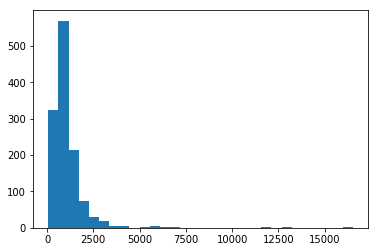

In [9]:
plt.hist(leaflets_length, bins=30)

In [11]:
# remove "outliers" - just make a better content extraction system! 

count_large_content = 0

for leaflet in loaded_package_leaflets:
    section1_content = leaflet.section1.section_content
    
    if len(section1_content) >= 3000:
        count_large_content += 1
        loaded_package_leaflets.remove(leaflet)

print(count_large_content)

1


In [12]:
leaflets_length = []

for leaflet in loaded_package_leaflets:
    leaflets_length.append(len(leaflet.section1.section_content))

In [13]:
len(loaded_package_leaflets)

1220

In [14]:
np.mean(leaflets_length)

961.7909836065573

(array([ 1.,  0.,  0.,  2.,  3.,  4.,  4., 12., 16., 16., 25., 23., 29.,
        29., 30., 33., 36., 40., 28., 36., 40., 38., 37., 32., 59., 32.,
        21., 36., 36., 29., 26., 29., 23., 21., 22., 26., 15., 19., 26.,
        18., 21., 10.,  9., 11.,  8., 11.,  7., 11., 13.,  4., 12.,  8.,
         9.,  5.,  8.,  6.,  8.,  5.,  2.,  2.,  3.,  6.,  7., 11.,  2.,
         4.,  5.,  3.,  3.,  4.,  5.,  2.,  1.,  1.,  2.,  0.,  1.,  1.,
         2.,  2.,  3.,  2.,  0.,  4.,  1.,  1.,  1.,  1.,  4.,  2.,  2.,
         1.,  2.,  2.,  3.,  0.,  1.,  1.,  0.,  2.]),
 array([  65.  ,   94.29,  123.58,  152.87,  182.16,  211.45,  240.74,
         270.03,  299.32,  328.61,  357.9 ,  387.19,  416.48,  445.77,
         475.06,  504.35,  533.64,  562.93,  592.22,  621.51,  650.8 ,
         680.09,  709.38,  738.67,  767.96,  797.25,  826.54,  855.83,
         885.12,  914.41,  943.7 ,  972.99, 1002.28, 1031.57, 1060.86,
        1090.15, 1119.44, 1148.73, 1178.02, 1207.31, 1236.6 , 1265.89,
        

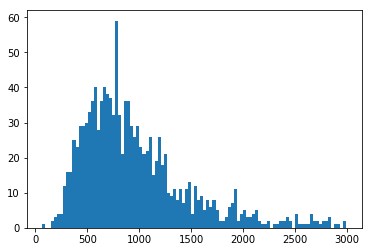

In [15]:
plt.hist(leaflets_length, bins=100)

In [16]:
    # split dataset into train-valid-test (1000-120-100) and shuffle 

    # train - test
    train_leaflets, test_leaflets = train_test_split(loaded_package_leaflets, test_size=100, random_state=42, shuffle=True)

    # train - valid 
    train_leaflets, valid_leaflets = train_test_split(train_leaflets, test_size=120, random_state=42, shuffle=True)

## Produce same output as the script *create_dataset* from data2text-plain

### Plan

section_content -------- true text   

entity_recognition  ------- actually input - set of records   

Set of records in order they appear in section_content    -------- content plan 

In [17]:
RECORD_DELIM = " "
DELIM = u"￨"

HOME = "HOME"
AWAY = "AWAY"

ENTITY = "Indication"

PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
UNK = 0
BOS_WORD = '<s>'
EOS_WORD = '</s>'

In [18]:
def create_summary_contentplan(dataset):
    """
    Transform dataset to be a suitable format for model data2text-plan
    """
    
    # array to store section1 of each leaflet
    summaries_leaflets = []
    
    # array to store content plan of each leaflet
    content_plan_leaflets = []
    
    for leaflet in dataset:
        
        # extract section1 content
        section1_content = leaflet.section1.section_content
        # extract results of NER
        section1_entity_recognition = leaflet.section1.entity_recognition

        # get the content plan of each section
        content_plan_section1 = ''

        for entity in section1_entity_recognition:
            entity_value = entity['Text'] if len(entity['Text'].split(" ")) == 0 else ("_").join(entity['Text'].split(" "))
            entity_type = entity['Type'] if entity['Type'] is not None and len(entity['Type']) > 0 else entity['Category']
            
            # randomly choose HOME or AWAY
            if random.randint(1,2) == 1:
                content_plan_section1 += entity_value + DELIM + ENTITY + DELIM + entity_type + DELIM + HOME
            else:
                content_plan_section1 += entity_value + DELIM + ENTITY + DELIM + entity_type + DELIM + AWAY
            
            if section1_entity_recognition.index(entity) != len(section1_entity_recognition) - 1:
                content_plan_section1 += " "
            else:
                content_plan_section1 += " " + "\n"


        content_plan_leaflets.append(content_plan_section1)

        # get the section1 content
        # make sure to have punctuations as a separate token
        section1_content = wordpunct_tokenize(section1_content)
        
        # remove "bulletpoints" tokens
        section1_content = [token for token in section1_content if token != "\uf02d" and token != "\uf0a7"]
        
        # back to string
        section1_content = " ".join(section1_content)
        
        # add "\n" at the end
        section1_content = section1_content + "\n"
        
        summaries_leaflets.append(section1_content)
    
    return (content_plan_leaflets, summaries_leaflets)

In [19]:
def add_special_records(records):
    """
    To src_train.txt and src_valid.txt pre-append these special characters, according to data2text-plan project
    """
    
    record = []
    record.append(UNK_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    records.append(DELIM.join(record))
    record = []
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    records.append(DELIM.join(record))
    record = []
    record.append(BOS_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    records.append(DELIM.join(record))
    record = []
    record.append(EOS_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    records.append(DELIM.join(record))
    
    return records

In [20]:
# get the src_train - training data to be input to the model


def create_src_table(content_plan_leaflets):
    """
    Create src_train - input "table" to the model
    
    Idea: - we do not have a table, so randomized the records in content plan
    """
    
    # store input "table" of each leaflet in array
    src_leaflets = []
    
    for leaflet_content_plan in content_plan_leaflets:
        # remove the end symbol ('\n') of the string
        leaflet_content_plan = leaflet_content_plan[:-2]

        # split string into a list of records
        leaflet_content_plan_collection = leaflet_content_plan.split(" ")
        
        # randomly shuffle records in a list
        random.shuffle(leaflet_content_plan_collection)
        
        # add special symbols to the begining
        special_symbols = []
        special_symbols = add_special_records(special_symbols)

        # create a string containing all the records and special_symbols in the begining
        src_leaflet_section1 = ''

        src_leaflet_section1 += " ".join(special_symbols)
        src_leaflet_section1 += " "

        src_leaflet_section1 += " ".join(leaflet_content_plan_collection)
        src_leaflet_section1 += '\n'


        src_leaflets.append(src_leaflet_section1)
    
    return src_leaflets

In [21]:
def create_training_sets(dataset):
    
    # Output files
    INTER_CONTENT_PLAN = 'inter/train_content_plan.txt'  # intermediate content plan input to second stage
    SRC_FILE = 'src_train.txt'  # src file input to first stage
    TRAIN_TGT_FILE = "tgt_train.txt"  # tgt file of second stage
    CONTENT_PLAN_OUT = 'train_content_plan.txt'  # content plan output of first stage
    
    # Create src - content_plan - summary
    content_plan_leaflets, summaries_leaflets = create_summary_contentplan(dataset)
    src_leaflets = create_src_table(content_plan_leaflets)
    
    # save to corresponding files
    output_file = open(INTER_CONTENT_PLAN, 'w')
    for content_plan in content_plan_leaflets:
        output_file.write(content_plan)
    output_file.close()
    
    summary_file = open(TRAIN_TGT_FILE, 'w')
    for summary_leaflet in summaries_leaflets:
        summary_file.write(summary_leaflet)
    summary_file.close()
    
    src_file = open(SRC_FILE, 'w')
    for src_instance in src_leaflets:
        src_file.write(src_instance)
    src_file.close()
    
    ### create last file needed - e.g (rotowire/train_content_plan.txt)
    inputs = []
    content_plans = []
    with codecs.open(INTER_CONTENT_PLAN, "r", "utf-8") as corpus_file:
        for i, line in enumerate(corpus_file):
            content_plans.append(line.split())

    with codecs.open(SRC_FILE, "r", "utf-8") as corpus_file:
        for i, line in enumerate(corpus_file):
            inputs.append(line.split())
    
    # basically - now content plan POINTs to index in the training dataset
    # content_plan - collection of indexes where each index points to record in training dataset - training_dataset[index]
    
    outputs = []

    for i, training_sample in enumerate(inputs):
        content_plan = content_plans[i]
        output = []
        for record in content_plan:
            output.append(str(training_sample.index(record)))
        outputs.append(" ".join(output))
        
    # write to a file

    output_file = open(CONTENT_PLAN_OUT, 'w')

    # add \n to the end of the string
    output_file.write("\n".join(outputs))
    # add \n between content plans
    output_file.write("\n")

    output_file.close()
    
    return src_leaflets, content_plan_leaflets, summaries_leaflets

In [22]:
leaflets_src_train, leaflets_inter_contentplan_train, leaflets_tgt_train = create_training_sets(train_leaflets)

In [43]:
with open('src_train.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    leaflet_src_train = reader.readlines()

## Check the *leaflets* training input files and *NBA* input files

In [115]:
with open('rotowire/train_content_plan.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    nba_train_contentplan = reader.readlines()

In [72]:
with open('train_content_plan.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    leaflet_train_contentplan = reader.readlines()

In [117]:
nba_train_contentplan[44]

'589 590 582 376 377 358 370 371 46 47 28 29 30 24 25 6 18 21\n'

In [73]:
leaflet_train_contentplan[65]

'8 5 5 10 9 12 27 15 11 5 11 28 26 22 19 15 14 24 12 8 6 15 16 7 18 4 9 12\n'

In [74]:
with open('rotowire/inter/train_content_plan.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    nba_inter_train_content_plan = reader.readlines()

In [75]:
with open('inter/train_content_plan.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    leaflet_inter_train_content_plan = reader.readlines()

In [76]:
nba_inter_train_content_plan[122]

'New_Orleans￨Pelicans￨TEAM-CITY￨HOME Pelicans￨Pelicans￨TEAM-NAME￨HOME 106￨Pelicans￨TEAM-PTS￨HOME Boston￨Celtics￨TEAM-CITY￨AWAY Celtics￨Celtics￨TEAM-NAME￨AWAY 105￨Celtics￨TEAM-PTS￨AWAY 40￨Celtics￨TEAM-FG_PCT￨AWAY 29￨Celtics￨TEAM-FG3_PCT￨AWAY 19￨Celtics￨TEAM-AST￨AWAY 16￨Pelicans￨TEAM-AST￨HOME 5￨Celtics￨TEAM-WINS￨AWAY 5￨Celtics￨TEAM-LOSSES￨AWAY Isaiah￨Isaiah_Thomas￨FIRST_NAME￨AWAY Thomas￨Isaiah_Thomas￨SECOND_NAME￨AWAY 37￨Isaiah_Thomas￨PTS￨AWAY 3￨Isaiah_Thomas￨REB￨AWAY 7￨Isaiah_Thomas￨AST￨AWAY Avery￨Avery_Bradley￨FIRST_NAME￨AWAY Bradley￨Avery_Bradley￨SECOND_NAME￨AWAY 19￨Avery_Bradley￨PTS￨AWAY 10￨Avery_Bradley￨REB￨AWAY Marcus￨Marcus_Smart￨FIRST_NAME￨AWAY Smart￨Marcus_Smart￨SECOND_NAME￨AWAY 15￨Marcus_Smart￨PTS￨AWAY 6￨Marcus_Smart￨REB￨AWAY 3￨Marcus_Smart￨AST￨AWAY 4￨Marcus_Smart￨STL￨AWAY 2￨Pelicans￨TEAM-WINS￨HOME 9￨Pelicans￨TEAM-LOSSES￨HOME Anthony￨Anthony_Davis￨FIRST_NAME￨HOME Davis￨Anthony_Davis￨SECOND_NAME￨HOME 25￨Anthony_Davis￨PTS￨HOME 16￨Anthony_Davis￨REB￨HOME 4￨Anthony_Davis￨STL￨HOME Tim

In [77]:
leaflet_inter_train_content_plan[12]

'follitropin￨Indication￨GENERIC_NAME￨AWAY infertility￨Indication￨DX_NAME￨AWAY vitro_fertilisation￨Indication￨PROCEDURE_NAME￨AWAY ivf￨Indication￨TREATMENT_NAME￨HOME intracytoplasmic_sperm_injection￨Indication￨TREATMENT_NAME￨AWAY ovaries￨Indication￨SYSTEM_ORGAN_SITE￨HOME \n'

In [78]:
with open('rotowire/src_train.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    nba_src_train = reader.readlines()

In [79]:
with open('src_train.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    leaflet_src_train = reader.readlines()

In [80]:
nba_src_train[45]

'<unk>￨<blank>￨<blank>￨<blank> <blank>￨<blank>￨<blank>￨<blank> <s>￨<blank>￨<blank>￨<blank> </s>￨<blank>￨<blank>￨<blank> F￨Wilson_Chandler￨START_POSITION￨HOME 28￨Wilson_Chandler￨MIN￨HOME 9￨Wilson_Chandler￨PTS￨HOME 2￨Wilson_Chandler￨FGM￨HOME 7￨Wilson_Chandler￨FGA￨HOME 29￨Wilson_Chandler￨FG_PCT￨HOME 0￨Wilson_Chandler￨FG3M￨HOME 0￨Wilson_Chandler￨FG3A￨HOME 0￨Wilson_Chandler￨FG3_PCT￨HOME 5￨Wilson_Chandler￨FTM￨HOME 8￨Wilson_Chandler￨FTA￨HOME 63￨Wilson_Chandler￨FT_PCT￨HOME 2￨Wilson_Chandler￨OREB￨HOME 6￨Wilson_Chandler￨DREB￨HOME 8￨Wilson_Chandler￨REB￨HOME 3￨Wilson_Chandler￨AST￨HOME 0￨Wilson_Chandler￨TO￨HOME 0￨Wilson_Chandler￨STL￨HOME 0￨Wilson_Chandler￨BLK￨HOME 1￨Wilson_Chandler￨PF￨HOME Wilson￨Wilson_Chandler￨FIRST_NAME￨HOME Chandler￨Wilson_Chandler￨SECOND_NAME￨HOME F￨Danilo_Gallinari￨START_POSITION￨HOME 36￨Danilo_Gallinari￨MIN￨HOME 27￨Danilo_Gallinari￨PTS￨HOME 9￨Danilo_Gallinari￨FGM￨HOME 19￨Danilo_Gallinari￨FGA￨HOME 47￨Danilo_Gallinari￨FG_PCT￨HOME 7￨Danilo_Gallinari￨FG3M￨HOME 14￨Danilo_Gallinar

In [81]:
leaflet_src_train[45]

'<unk>￨<blank>￨<blank>￨<blank> <blank>￨<blank>￨<blank>￨<blank> <s>￨<blank>￨<blank>￨<blank> </s>￨<blank>￨<blank>￨<blank> lungs￨Indication￨SYSTEM_ORGAN_SITE￨AWAY adcirca￨Indication￨BRAND_NAME￨HOME pulmonary_arterial_hypertension￨Indication￨DX_NAME￨AWAY lungs￨Indication￨SYSTEM_ORGAN_SITE￨AWAY phosphodiesterase_type_5_(pde5)_inhibitors￨Indication￨TREATMENT_NAME￨HOME adcirca￨Indication￨BRAND_NAME￨HOME tadalafil￨Indication￨GENERIC_NAME￨AWAY\n'

In [82]:
with open('rotowire/tgt_train.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    nba_tgt_train = reader.readlines()

In [83]:
with open('tgt_train.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    leaflet_tgt_train = reader.readlines()

In [84]:
leaflet_tgt_train[21]

'Pemetrexed Sandoz is a medicine used in the treatment of cancer . Pemetrexed Sandoz is given in combination with cisplatin , another anti - cancer medicine , as treatment for malignant pleural mesothelioma , a form of cancer that affects the lining of the lung , to patients who have not received prior chemotherapy . Pemetrexed Sandoz is also given in combination with cisplatin for the initial treatment of patients with advanced stage of lung cancer . Pemetrexed Sandoz can be prescribed to you if you have lung cancer at an advanced stage if your disease has responded to treatment or it remains largely unchanged after initial chemotherapy . Pemetrexed Sandoz is also a treatment for patients with advanced stage of lung cancer whose disease has progressed after other initial chemotherapy has been used .\n'

In [85]:
nba_tgt_train[21]

"The Atlanta Hawks defeated the Miami Heat , 103 - 95 , at Philips Arena on Wednesday . Atlanta was in desperate need of a win and they were able to take care of a shorthanded Miami team here . Defense was key for the Hawks , as they held the Heat to 42 percent shooting and forced them to commit 16 turnovers . Atlanta also dominated in the paint , winning the rebounding battle , 47 - 34 , and outscoring them in the paint 58 - 26.The Hawks shot 49 percent from the field and assisted on 27 of their 43 made baskets . This was a near wire - to - wire win for the Hawks , as Miami held just one lead in the first five minutes . Miami ( 7 - 15 ) are as beat - up as anyone right now and it 's taking a toll on the heavily used starters . Hassan Whiteside really struggled in this game , as he amassed eight points , 12 rebounds and one blocks on 4 - of - 12 shooting . Tyler Johnson was the team 's best player , as he tallied 27 points and five assists off the bench . Goran Dragic continued his goo

==============================================================================================================================
## Validation dataset 

In [25]:
len(valid_leaflets)

120

In [26]:
def create_validation_sets(dataset):
    
    # Output files    
    INTER_CONTENT_PLAN_VALID = 'inter/valid_content_plan.txt'  # intermediate content plan input to second stage
    SRC_FILE_VALID = 'src_valid.txt'  # src file input to first stage
    TRAIN_TGT_FILE_VALID = "tgt_valid.txt"  # tgt file of second stage
    CONTENT_PLAN_OUT_VALID = 'valid_content_plan.txt'  # content plan output of first stage
    
    # Create src - content_plan - summary
    content_plan_leaflets, summaries_leaflets = create_summary_contentplan(dataset)
    src_leaflets = create_src_table(content_plan_leaflets)
    
    # save to corresponding files
    output_file = open(INTER_CONTENT_PLAN_VALID, 'w')
    for content_plan in content_plan_leaflets:
        output_file.write(content_plan)
    output_file.close()
    
    summary_file = open(TRAIN_TGT_FILE_VALID, 'w')
    for summary_leaflet in summaries_leaflets:
        summary_file.write(summary_leaflet)
    summary_file.close()
    
    src_file = open(SRC_FILE_VALID, 'w')
    for src_instance in src_leaflets:
        src_file.write(src_instance)
    src_file.close()
    
    ### create last file needed - e.g (rotowire/train_content_plan.txt)
    inputs = []
    content_plans = []
    with codecs.open(INTER_CONTENT_PLAN_VALID, "r", "utf-8") as corpus_file:
        for i, line in enumerate(corpus_file):
            content_plans.append(line.split())

    with codecs.open(SRC_FILE_VALID, "r", "utf-8") as corpus_file:
        for i, line in enumerate(corpus_file):
            inputs.append(line.split())
    
    # basically - now content plan POINTs to index in the training dataset
    # content_plan - collection of indexes where each index points to record in training dataset - training_dataset[index]
    
    outputs = []

    for i, training_sample in enumerate(inputs):
        content_plan = content_plans[i]
        output = []
        for record in content_plan:
            output.append(str(training_sample.index(record)))
        outputs.append(" ".join(output))
        
    # write to a file

    output_file = open(CONTENT_PLAN_OUT_VALID, 'w')

    # add \n to the end of the string
    output_file.write("\n".join(outputs))
    # add \n between content plans
    output_file.write("\n")

    output_file.close()
    
    return src_leaflets, content_plan_leaflets, summaries_leaflets

In [27]:
leaflets_src_valid, leaflets_inter_contentplan_valid, leaflets_tgt_valid = create_validation_sets(valid_leaflets)

In [129]:
with open('valid_content_plan.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    leaflet_contentplan_valid = reader.readlines()

================================================================================================================================
## Test dataset 

In [28]:
len(test_leaflets)

100

In [29]:
def create_test_sets(dataset):
    
    # Output files
    SRC_FILE_TEST = 'test/src_test.txt'  # src file input to first stage
    TRAIN_TGT_FILE_TEST = "test/tgt_test.txt"  # tgt file of second stage 
    
    
    # Create src - content_plan - summary
    content_plan_leaflets, summaries_leaflets = create_summary_contentplan(dataset)
    src_leaflets = create_src_table(content_plan_leaflets)
    
    # save to just summary and src data
    
    summary_file = open(TRAIN_TGT_FILE_TEST, 'w')
    for summary_leaflet in summaries_leaflets:
        summary_file.write(summary_leaflet)
    summary_file.close()
    
    src_file = open(SRC_FILE_TEST, 'w')
    for src_instance in src_leaflets:
        src_file.write(src_instance)
    src_file.close()

    return src_leaflets, summaries_leaflets

In [30]:
leaflets_src_test, leaflets_tgt_test = create_test_sets(test_leaflets)

=======================================================================================================================
## Creating *train-roto-ptrs.txt*

In [31]:
# Output files
INTER_CONTENT_PLAN = 'inter/train_content_plan.txt'  # intermediate content plan input to second stage
TRAIN_TGT_FILE = "tgt_train.txt"  # tgt file of second stage
OUTPUT_FILE = "train-roto-ptrs.txt"

In [32]:
with open(TRAIN_TGT_FILE) as reader:
    leaflet_tgt_train = reader.readlines()

In [33]:
with open(INTER_CONTENT_PLAN) as reader:
    leaflets_inter_content_plan = reader.readlines()

For eg: the last entry 245,39 in train_roto_ptrs[1] indicates that the 245th token in summary matches with 39th content plan entry.  

Phoenix ----> Phoenix￨Suns￨TEAM-CITY￨HOME  
Suns ----> Suns￨Suns￨TEAM-NAME￨HOME  
39 ----> 39￨Suns￨TEAM-WINS￨HOME  
38 ----> 38￨Suns￨TEAM-LOSSES￨HOME  
87 ----> 87￨Suns￨TEAM-PTS￨HOME  
85 ----> 85￨Jazz￨TEAM-PTS￨AWAY  
Utah ----> Utah￨Jazz￨TEAM-CITY￨AWAY  

In [34]:
roto_pts_content = []

# for each leaflet
for leflet_num in range(len(leaflet_tgt_train)):
    
    # get current leaflet and content plan
    current_leaflet = leaflet_tgt_train[leflet_num].split()
    current_content_plan = leaflets_inter_content_plan[leflet_num].split()
    
    # get the values of content plan
    instances = []
    for entry in current_content_plan:
        record_values = entry.split(DELIM)[0]
        instances.append(record_values)
    
    # pairs (index_tgt, index_contentplan) for each leaflet
    current_str = []
    
    # for each token in current summary
    for token_pos in range(len(current_leaflet)):
        
        # get token
        token = current_leaflet[token_pos]
        
        # possible tokens if 2 words in content plan like 'immunodeficiency_syndrome'
        if token_pos != (len(current_leaflet)-1):
            token_2words = current_leaflet[token_pos] + "_" + current_leaflet[token_pos+1]
        
        for content_plan_index in range(len(instances)):
            
            if token == instances[content_plan_index]:
                # mask the corresponding position in content plan
                instances[content_plan_index] = "MASKED"
                pair = str(token_pos) + "," + str(content_plan_index)
                current_str.append(pair)
                # find just one match
                break
                
            elif token_2words == instances[content_plan_index]:
                # mask the corresponding position in content plan
                instances[content_plan_index] = "MASKED"
                pair = str(token_pos) + "," + str(content_plan_index)
                current_str.append(pair)

                # find just one match
                break
    
    # join pairs into string with " " between pairs
    current_str = " ".join(current_str)
    
    # add "\n" at the end
    current_str += "\n"
    
    roto_pts_content.append(current_str)

In [35]:
OUTPUT_FILE = "train-roto-ptrs.txt"

src_file = open(OUTPUT_FILE, 'w')
for src_instance in roto_pts_content:
    src_file.write(src_instance)
src_file.close()

In [36]:
len(roto_pts_content)

1000

In [37]:
roto_pts_content[222]

'0,0 5,1 7,2 14,3 43,4 46,5 64,7 65,11 89,8 107,9 130,10 137,12\n'

In [38]:
len(roto_pts_content[22].split())

17

In [39]:
len(leaflets_inter_content_plan[22].split())

18

### Check whether correct

In [40]:
content_plan_indeces = []

for pair in roto_pts_content[100].split():
    pair = pair.split(",")
    
    a = int(pair[0])
    b = int(pair[1])
    
    content_plan_indeces.append(b)
    
    print(leaflet_tgt_train[100].split()[a], end=" ----> ")
    print(leaflets_inter_content_plan[100].split()[b])
    

epoetin ----> epoetin_zeta￨Indication￨GENERIC_NAME￨HOME
bone ----> bone_marrow￨Indication￨SYSTEM_ORGAN_SITE￨AWAY
haemodialysis ----> haemodialysis￨Indication￨TREATMENT_NAME￨HOME
anaemia ----> anaemia￨Indication￨DX_NAME￨AWAY
renal ----> renal_failure￨Indication￨DX_NAME￨AWAY
kidney ----> kidney￨Indication￨SYSTEM_ORGAN_SITE￨HOME
peritoneal ----> peritoneal_dialysis￨Indication￨PROCEDURE_NAME￨AWAY
dialysis ----> dialysis￨Indication￨TREATMENT_NAME￨AWAY
anaemia ----> anaemia￨Indication￨DX_NAME￨HOME
renal ----> renal_failure￨Indication￨DX_NAME￨HOME
kidney ----> kidney_disease￨Indication￨DX_NAME￨AWAY
renal ----> renal_insufficiency￨Indication￨DX_NAME￨HOME
anaemia ----> anaemia￨Indication￨DX_NAME￨AWAY
kidney ----> kidney￨Indication￨SYSTEM_ORGAN_SITE￨AWAY
chemotherapy ----> chemotherapy￨Indication￨TREATMENT_NAME￨AWAY
solid ----> solid_tumours￨Indication￨DX_NAME￨HOME
malignant ----> malignant_lymphoma￨Indication￨DX_NAME￨HOME
cancer ----> cancer￨Indication￨DX_NAME￨HOME
lymphatic ----> lymphatic_sys

In [41]:
len(leaflets_inter_content_plan[0].split())

78

In [42]:
len(roto_pts_content[0].split())

68

In [43]:
# check out pairs missed
for i in range(0, len(leaflets_inter_content_plan[100].split()), 1):
    if i not in content_plan_indeces:
        print(leaflets_inter_content_plan[100].split()[i])
        
# explanation - 3-word long token
# explanation - hiv_infection ---> bc NER outputs - 'hiv', 'hiv_infection' - in content plan I have 2 tokens starting with 'hiv'

kidney_disease￨Indication￨DX_NAME￨HOME
kidney￨Indication￨SYSTEM_ORGAN_SITE￨AWAY
kidney_disease￨Indication￨DX_NAME￨HOME
bone_marrow_cancer￨Indication￨DX_NAME￨HOME
knee_replacement_operations￨Indication￨PROCEDURE_NAME￨AWAY


In [69]:
leaflet_tgt_train[0]

'what is fosavance ? fosavance is a tablet containing the two active substances , alendronic acid ( commonly called alendronate ) and colecalciferol known as vitamin d3 . what is alendronate ? alendronate belongs to a group of nonhormonal medicines called bisphosphonates . alendronate prevents the loss of bone that occurs in women after they have been through the menopause , and helps to rebuild bone . it reduces the risk of spine and hip fractures . what is vitamin d ? vitamin d is an essential nutrient , required for calcium absorption and healthy bones . the body can only absorb calcium properly from our food if it has enough vitamin d . very few foods contain vitamin d . the main source is through exposure to summer sunlight , which makes vitamin d in our skin . as we get older our skin makes less vitamin d . too little vitamin d may lead to bone loss and osteoporosis . severe vitamin d deficiency may cause muscle weakness which can lead to falls and a greater risk of fractures . w

Remark - Consider changing the order: 1st check whether token_2word in summary, and only then consider other tokens.

# Check how original files are represented

In [24]:
with open('rotowire/tgt_train.txt') as reader:
    original_tgt_train = reader.readlines()

In [83]:
original_tgt_train[123]

"The Dallas Mavericks ( 18 - 13 ) defeated the Milwaukee Bucks ( 12 - 20 ) 103 - 93 on Monday night . Dallas led 34 - 24 after the first quarter and never relinquished the lead after that . The Bucks came into this game as the worst rebounding team in the NBA , but actually outrebounded Dallas 52 - 34 in the loss . They also outshot Dallas and that 's a rare sight to see a team win when getting outrebounded and outshot . The difference for the Mavericks were the turnovers , as they committed just four to the Bucks 17 . Milwaukee has been terrible on the road all season and they didn’t play great here . No player scored more than 19 points and the team had a lack of offensive execution that was clearly evident . In fact , Milwaukee had just 14 assists and that 's not good enough in an NBA game . Jerryd Bayless made his return from injury and played brilliantly , contributing 19 points and seven assists off the bench . The road woes are a big worry for this team and it 'll likely get wor

In [173]:
with open('rotowire/src_valid.txt') as reader:
    original_tgt_valid = reader.readlines()

In [93]:
with open('inter/valid_content_plan.txt') as reader:
    leaflets_inter_contentplan_valid = reader.readlines()

In [99]:
leaflets_src_valid[100]

'<unk>￨<blank>￨<blank>￨<blank> <blank>￨<blank>￨<blank>￨<blank> <s>￨<blank>￨<blank>￨<blank> </s>￨<blank>￨<blank>￨<blank> inflammation￨Indication￨DX_NAME￨HOME eye￨Indication￨SYSTEM_ORGAN_SITE￨AWAY artificial_tears￨Indication￨GENERIC_NAME￨AWAY artificial_tears￨Indication￨TREATMENT_NAME￨HOME dry_eye_disease￨Indication￨DX_NAME￨HOME immunosuppressive_agents￨Indication￨TREATMENT_NAME￨AWAY keratitis￨Indication￨DX_NAME￨HOME ciclosporin￨Indication￨GENERIC_NAME￨HOME inflammation￨Indication￨DX_NAME￨AWAY ciclosporin￨Indication￨GENERIC_NAME￨AWAY cornea￨Indication￨SYSTEM_ORGAN_SITE￨AWAY eye￨Indication￨SYSTEM_ORGAN_SITE￨AWAY\n'

In [90]:
leaflets_tgt_valid[0]

'kinzalmono belongs to a class of medicines known as angiotensin ii receptor antagonists . angiotensin ii is a substance produced in your body which causes your blood vessels to narrow , thus increasing your blood pressure . kinzalmono blocks the effect of angiotensin ii so that the blood vessels relax , and your blood pressure is lowered . kinzalmono is used to treat essential hypertension ( high blood pressure ) in adults . ‘ essential ’ means that the high blood pressure is not caused by any other condition . high blood pressure , if not treated , can damage blood vessels in several organs , which could lead sometimes to heart attack , heart or kidney failure , stroke , or blindness . there are usually no symptoms of high blood pressure before damage occurs . thus it is important to regularly measure blood pressure to verify if it is within the normal range . kinzalmono is also used to reduce cardiovascular events ( i . e . heart attack or stroke ) in adults who are at risk because 

In [95]:
len(leaflets_contentplan_valid[0].split())

32

In [98]:
leaflets_inter_contentplan_valid[0]

'body￨Indication￨SYSTEM_ORGAN_SITE￨HOME blood_vessels￨Indication￨SYSTEM_ORGAN_SITE￨HOME blood_vessels_to_narrow￨Indication￨DX_NAME￨AWAY blood_pressure￨Indication￨TEST_NAME￨AWAY blood_pressure￨Indication￨DX_NAME￨HOME kinzalmono_blocks￨Indication￨TEST_NAME￨HOME blood_vessels￨Indication￨SYSTEM_ORGAN_SITE￨HOME blood_pressure￨Indication￨TEST_NAME￨AWAY kinzalmono￨Indication￨GENERIC_NAME￨HOME hypertension￨Indication￨DX_NAME￨HOME high_blood_pressure￨Indication￨DX_NAME￨AWAY high_blood_pressure￨Indication￨DX_NAME￨HOME high_blood_pressure￨Indication￨DX_NAME￨AWAY damage_blood_vessels￨Indication￨DX_NAME￨AWAY blood_vessels￨Indication￨SYSTEM_ORGAN_SITE￨AWAY heart￨Indication￨SYSTEM_ORGAN_SITE￨AWAY heart_attack￨Indication￨DX_NAME￨AWAY heart￨Indication￨SYSTEM_ORGAN_SITE￨AWAY heart_or_kidney_failure￨Indication￨DX_NAME￨AWAY kidney￨Indication￨SYSTEM_ORGAN_SITE￨AWAY stroke￨Indication￨DX_NAME￨HOME blindness￨Indication￨DX_NAME￨HOME high_blood_pressure￨Indication￨DX_NAME￨AWAY damage￨Indication￨DX_NAME￨AWAY hea

In [7]:
with open('inter/train_content_plan.txt') as reader:
    original_src_valid = reader.readlines()

In [11]:
original_src_valid[0].split()

['alendronic_acid￨Indication￨GENERIC_NAME￨HOME',
 'alendronate￨Indication￨GENERIC_NAME￨HOME',
 'colecalciferol￨Indication￨GENERIC_NAME￨AWAY',
 'vitamin_d3￨Indication￨GENERIC_NAME￨AWAY',
 'alendronate￨Indication￨GENERIC_NAME￨HOME',
 'alendronate￨Indication￨GENERIC_NAME￨AWAY',
 'alendronate￨Indication￨GENERIC_NAME￨HOME',
 'loss_of_bone￨Indication￨DX_NAME￨HOME',
 'bone￨Indication￨SYSTEM_ORGAN_SITE￨AWAY',
 'menopause￨Indication￨DX_NAME￨AWAY',
 'bone￨Indication￨SYSTEM_ORGAN_SITE￨HOME',
 'spine￨Indication￨SYSTEM_ORGAN_SITE￨AWAY',
 'hip￨Indication￨SYSTEM_ORGAN_SITE￨AWAY',
 'hip_fractures￨Indication￨DX_NAME￨HOME',
 'bones￨Indication￨SYSTEM_ORGAN_SITE￨AWAY',
 'body￨Indication￨SYSTEM_ORGAN_SITE￨AWAY',
 'vitamin_d￨Indication￨GENERIC_NAME￨AWAY',
 'skin￨Indication￨SYSTEM_ORGAN_SITE￨AWAY',
 'skin￨Indication￨SYSTEM_ORGAN_SITE￨AWAY',
 'bone￨Indication￨SYSTEM_ORGAN_SITE￨AWAY',
 'bone_loss￨Indication￨DX_NAME￨AWAY',
 'osteoporosis￨Indication￨DX_NAME￨HOME',
 'vitamin_d_deficiency￨Indication￨DX_NAME￨HOME',